# Controllers

To actively manipulate the computing or energy systems during experiments, we need to implement a custom `Controller`.

In this example, our controller will adjust the power consumption of the compute nodes depending on the current power delta. 

In [1]:
from __future__ import annotations
import vessim as vs

# Hotfix to execute asyncio in Jupyter
import nest_asyncio
nest_asyncio.apply()

The most important aspect of this procedure is the implementation of the
`step()` method, which needs to be implemented as dictated by the Controller
ABC. The `step()` method is called every simulation step and allows a Controller
to act on the power delta from the Microgrid, the current simulation time and
the activity of the Actors. The `SimpleLoadBalancingController` only utilizes
the power delta and adjusts, depending on this value, the power consumption of
the computing system and in turn the power delta in the next simulation step.

In [2]:
class SimpleLoadBalancingController(vs.Controller):
    def __init__(self, nodes: list[vs.MockSignal]):
        super().__init__()
        self.nodes = nodes
        # save original node power consumption
        self.node_p = {node.name: node.now() for node in self.nodes}

    def step(self, time: int, p_delta: float, e_delta: float, state: dict) -> None:
        for node in self.nodes:
            new_power = self.node_p[node.name]
            if p_delta < 0:
                new_power *= 0.3
            node.set_value(new_power)

Now we can add the controller to the basic scenario by instantiating it with a
reference to the power meters it can control and the maximum load adjustment for
each step. The rest of the scenario remains unchanged.

In [3]:
environment = vs.Environment(sim_start="2022-06-09 00:00:00")

nodes: list = [
    vs.MockSignal(value=200),
    vs.MockSignal(value=250),
]
monitor = vs.Monitor()  # Stores simulation result on each step
load_balancer = SimpleLoadBalancingController(nodes=nodes)
environment.add_microgrid(
    actors=[
        vs.ComputingSystem(nodes=nodes, pue=1.6),
        vs.Actor(
            name="solar",
            signal=vs.HistoricalSignal.load(
                "solcast2022_global", column="Berlin", params={"scale": 5000}
            ),
        ),
    ],
    storage=vs.SimpleBattery(capacity=500, initial_soc=0.8),
    controllers=[monitor, load_balancer],
    step_size=60,  # Global step size (can be overridden by actors or controllers)
)

environment.run(until=24 * 3600)  # 24h
monitor.to_csv("result.csv")

2024-06-21 11:43:37.514 | INFO     | mosaik.scenario:start:311 - Starting "Actor" as "ComputingSystem-0" ...
2024-06-21 11:43:37.515 | INFO     | mosaik.scenario:start:311 - Starting "Actor" as "solar" ...
2024-06-21 11:43:37.516 | INFO     | mosaik.scenario:start:311 - Starting "Grid" as "Grid-0" ...
2024-06-21 11:43:37.516 | INFO     | mosaik.scenario:start:311 - Starting "Controller" as "Monitor-0" ...
2024-06-21 11:43:37.517 | INFO     | mosaik.scenario:start:311 - Starting "Controller" as "SimpleLoadBalancingController-0" ...
2024-06-21 11:43:37.518 | INFO     | mosaik.scenario:start:311 - Starting "Storage" as "Storage-0" ...
2024-06-21 11:43:37.519 | INFO     | mosaik.scenario:run:651 - Starting simulation.
100%|██████████| 86400/86400 [00:01<00:00, 51383.86steps/s]
2024-06-21 11:43:39.203 | INFO     | mosaik.scenario:run:708 - Simulation finished successfully.


Compared to the basic example, our computing system utilizes less power from the grid when solar energy production is inadequate, thanks to our load balancer.

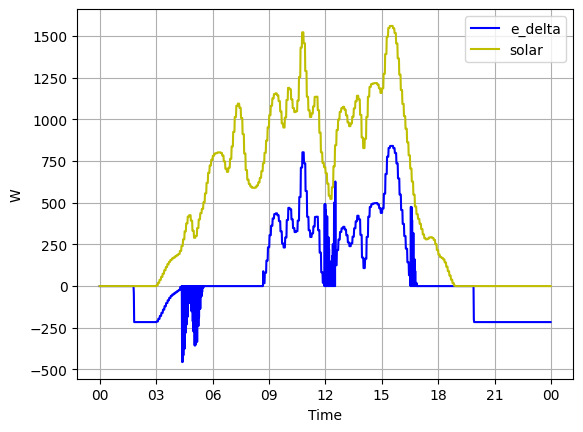

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv("result.csv", parse_dates=[0], index_col=0)
# divide e_delta by step size because e_delta is energy
df["grid_power"] = df["e_delta"] / 60

fig, ax1 = plt.subplots()

ax1.plot(df.index, df["grid_power"], color="b", label="e_delta")
ax1.legend()
ax1.plot(df.index, df["solar.p"], color="y", label="solar")
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("W")

plt.show()